# Histogram Equalization Pipeline for Intrinsic Decomposition

This notebook replicates the intrinsic decomposition workflow from `main.ipynb`, but first applies histogram equalization to:

- All ARAP dataset input images.
- The first 300 IIW dataset images (numeric order).

After preprocessing, we run the ordinal shading models on the equalized images and evaluate:

- ARAP: LMSE, RMSE, SSIM against ground-truth albedo & shading.
- IIW: WHDR on reflectance (albedo) predictions.

We also include optional qualitative visualization and integrity/runtime checks.

> Note: If a path for IIW histogram-equal output was misspelled in instructions (`histo_equal_outpu`), we assume the intended path is `histo_equal_output`. Adjust the path below if needed.

In [13]:
import sys
sys.path.insert(0, "imports")

In [14]:
# 2. Define Paths & Create Directories
import os
from pathlib import Path

# Raw-string Windows paths
ARAP_INPUT = r"E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\Input_Images"
ARAP_EQ_INPUT = r"E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\histo_equal_input"
ARAP_EQ_OUTPUT = r"E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\histo_equal_output"
ARAP_EQ_OUTPUT_ALB = os.path.join(ARAP_EQ_OUTPUT, "albedo")
ARAP_EQ_OUTPUT_SHD = os.path.join(ARAP_EQ_OUTPUT, "shading")

IIW_INPUT = r"E:\COLLEGE MATERIAL\Ordinal_Shading\IIW Dataset\data\images"
IIW_EQ_INPUT = r"E:\COLLEGE MATERIAL\Ordinal_Shading\IIW Dataset\data\histo_equal_images"
IIW_EQ_OUTPUT = r"E:\COLLEGE MATERIAL\Ordinal_Shading\IIW Dataset\data\histo_equal_output"
IIW_ANNOTATIONS = r"E:\COLLEGE MATERIAL\Ordinal_Shading\IIW Dataset\data\annotations"



for d in [ARAP_EQ_INPUT, ARAP_EQ_OUTPUT_ALB, ARAP_EQ_OUTPUT_SHD, IIW_EQ_INPUT, IIW_EQ_OUTPUT]:
    os.makedirs(d, exist_ok=True)

print("✅ Created/verified equalized input/output directories.")

✅ Created/verified equalized input/output directories.


In [20]:

import os
import glob
from tqdm import tqdm
import torch

In [15]:
# 3. Histogram Equalization Utilities
import numpy as np
from PIL import Image

try:
    import cv2
    _HAS_CV2 = True
except ImportError:
    _HAS_CV2 = False

from skimage import exposure

def to_uint8(arr: np.ndarray) -> np.ndarray:
    arr = np.clip(arr, 0, 1)
    return (arr * 255).astype(np.uint8)

def eq_luminance_rgb(img: np.ndarray, method: str = "clahe", clip_limit=2.0, tile_grid_size=(8,8)) -> np.ndarray:
    """Apply histogram equalization to luminance channel only.
    Priority: OpenCV CLAHE (if available) else skimage exposure.equalize_hist on Y-like channel.
    Expects float (0..1) or uint8; returns float 0..1."""
    orig_dtype = img.dtype
    if img.dtype != np.uint8:
        img8 = to_uint8(img)
    else:
        img8 = img
    # Convert to YCrCb (OpenCV) or HSV fallback
    if _HAS_CV2:
        ycrcb = cv2.cvtColor(img8, cv2.COLOR_RGB2YCrCb)
        Y, Cr, Cb = cv2.split(ycrcb)
        if method.lower() == 'clahe':
            clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
            Y_eq = clahe.apply(Y)
        else:
            Y_eq = cv2.equalizeHist(Y)
        ycrcb_eq = cv2.merge([Y_eq, Cr, Cb])
        rgb_eq = cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2RGB)
    else:
        # Fallback: convert to HSV using pillow
        pil_img = Image.fromarray(img8)
        hsv = pil_img.convert('HSV')
        h, s, v = hsv.split()
        v_arr = np.asarray(v).astype(np.float32) / 255.0
        v_eq = exposure.equalize_hist(v_arr)
        v_u8 = to_uint8(v_eq)
        hsv_eq = Image.merge('HSV', (h, s, Image.fromarray(v_u8)))
        rgb_eq = np.asarray(hsv_eq.convert('RGB'))
    rgb_eq = rgb_eq.astype(np.float32) / 255.0
    return rgb_eq

def batch_equalize(src_dir: str, dst_dir: str, limit: int | None = None, force=False):
    import os
    from tqdm import tqdm
    exts = ('.png','.jpg','.jpeg','.PNG','.JPG','.JPEG')
    files = [f for f in os.listdir(src_dir) if f.endswith(exts)]
    files.sort()
    if limit:
        files = files[:limit]
    processed = 0
    for f in tqdm(files, desc=f"Equalizing ({os.path.basename(src_dir)})"):
        in_path = os.path.join(src_dir, f)
        out_path = os.path.join(dst_dir, f)
        if (not force) and os.path.exists(out_path):
            continue
        try:
            arr = np.asarray(Image.open(in_path).convert('RGB')).astype(np.float32)/255.0
            eq = eq_luminance_rgb(arr)
            Image.fromarray(to_uint8(eq)).save(out_path)
            processed += 1
        except Exception as e:
            print(f"Skip {f}: {e}")
    print(f"✅ Equalization done for {src_dir} → {dst_dir}. Wrote {processed} new files (total now {len(os.listdir(dst_dir))}).")

In [8]:
# 4. ARAP: Generate Histogram-Equalized Inputs
batch_equalize(ARAP_INPUT, ARAP_EQ_INPUT, limit=None, force=False)

# Sanity check counts
import os
orig = len([f for f in os.listdir(ARAP_INPUT) if f.lower().endswith(('.png','.jpg','.jpeg'))])
eqct = len([f for f in os.listdir(ARAP_EQ_INPUT) if f.lower().endswith(('.png','.jpg','.jpeg'))])
print(f"Original ARAP count: {orig} | Equalized present: {eqct}")

Equalizing (Input_Images): 100%|██████████| 21/21 [00:03<00:00,  5.56it/s]

✅ Equalization done for E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\Input_Images → E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\histo_equal_input. Wrote 21 new files (total now 21).
Original ARAP count: 21 | Equalized present: 21


In [4]:
# 5. IIW: Generate Histogram-Equalized Inputs (First 1000 Images)
import re, os

def numeric_sort_key(fname: str):
    stem = os.path.splitext(fname)[0]
    m = re.match(r'^(\d+)', stem)
    if m:
        return (int(m.group(1)), stem.lower())
    return (float('inf'), stem.lower())

all_iiw = [f for f in os.listdir(IIW_INPUT) if f.lower().endswith(('.png','.jpg','.jpeg'))]
all_iiw.sort(key=numeric_sort_key)
subset = all_iiw[:1000]
print(f"Total IIW images: {len(all_iiw)} | Taking first 1000: {len(subset)}")

from tqdm import tqdm
processed = 0
for f in tqdm(subset, desc="Equalizing IIW (first 1000)"):
    src = os.path.join(IIW_INPUT, f)
    dst = os.path.join(IIW_EQ_INPUT, f)
    if os.path.exists(dst):
        continue
    try:
        arr = np.asarray(Image.open(src).convert('RGB')).astype(np.float32)/255.0
        eq = eq_luminance_rgb(arr)
        Image.fromarray(to_uint8(eq)).save(dst)
        processed += 1
    except Exception as e:
        print(f"Skip {f}: {e}")
print(f"✅ IIW equalization complete. Newly written: {processed} | Total present: {len(os.listdir(IIW_EQ_INPUT))}")

Total IIW images: 5230 | Taking first 1000: 1000


Equalizing IIW (first 1000): 100%|██████████| 1000/1000 [01:02<00:00, 16.12it/s]


✅ IIW equalization complete. Newly written: 1000 | Total present: 1000


In [5]:
# 5B. Synthetic Dense: Generate Histogram-Equalized Inputs
import os
from pathlib import Path

# Configure Synthetic Dense paths (raw Windows strings)
SYN_DENSE_INPUT = r"E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\Base_input"
SYN_DENSE_EQ_INPUT = r"E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\histo_equal_input"

# Create destination directory
os.makedirs(SYN_DENSE_EQ_INPUT, exist_ok=True)

# Reuse batch_equalize utility defined earlier
batch_equalize(SYN_DENSE_INPUT, SYN_DENSE_EQ_INPUT, limit=None, force=False)

# Sanity check counts
orig_sd = len([f for f in os.listdir(SYN_DENSE_INPUT) if f.lower().endswith(('.png','.jpg','.jpeg'))])
eq_sd = len([f for f in os.listdir(SYN_DENSE_EQ_INPUT) if f.lower().endswith(('.png','.jpg','.jpeg'))])
print(f"Synthetic Dense original count: {orig_sd} | Equalized present: {eq_sd}")

Equalizing (Base_input): 100%|██████████| 23/23 [00:01<00:00, 13.98it/s]

✅ Equalization done for E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\Base_input → E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\histo_equal_input. Wrote 23 new files (total now 23).
Synthetic Dense original count: 23 | Equalized present: 23


In [16]:
# 6. Load Ordinal Shading / Intrinsic Models (Local Weights)
import torch
from intrinsic.pipeline import run_pipeline
from altered_midas.midas_net import MidasNet
from altered_midas.midas_net_custom import MidasNet_small
from chrislib.general import view, invert
from chrislib.data_util import load_image

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

MODEL_DIR = "models"  # assumes same relative folder

ord_model = MidasNet()
ord_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, "stage_0_v21.pt"), map_location=device))
ord_model.eval().to(device)

iid_model = MidasNet_small(exportable=False, input_channels=5, output_channels=1)
iid_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, "stage_1_v21.pt"), map_location=device))
iid_model.eval().to(device)

col_model = MidasNet(activation='sigmoid', input_channels=7, output_channels=2)
col_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, "stage_2_v21.pt"), map_location=device))
col_model.eval().to(device)

alb_model = MidasNet(activation='sigmoid', input_channels=9, output_channels=3, last_residual=True)
alb_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, "stage_3_v21.pt"), map_location=device))
alb_model.eval().to(device)

dif_model = MidasNet(activation='sigmoid', input_channels=9, output_channels=3)
dif_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, "stage_4_v21.pt"), map_location=device))
dif_model.eval().to(device)

models = {
    "ord_model": ord_model,
    "iid_model": iid_model,
    "col_model": col_model,
    "alb_model": alb_model,
    "dif_model": dif_model,
}
print("✅ Models loaded (equalization pipeline)")

Using device: cpu


Using cache found in C:\Users\Arnav Jalan/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\Arnav Jalan/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
Using cache found in C:\Users\Arnav Jalan/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
Using cache found in C:\Users\Arnav Jalan/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\Arnav Jalan/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\Arnav Jalan/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\Arnav Jalan/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\Arnav Jalan/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\Arnav Jalan/.cache\torch\hub\facebookresearch_WSL-Images_main


✅ Models loaded (equalization pipeline)


In [11]:
# 7. Run Pipeline on ARAP Histogram-Equalized Inputs
from tqdm import tqdm
from imageio import imwrite

arap_eq_images = [f for f in os.listdir(ARAP_EQ_INPUT) if f.lower().endswith(('.png','.jpg','.jpeg'))]
arap_eq_images.sort()
print(f"Equalized ARAP images: {len(arap_eq_images)}")

for f in tqdm(arap_eq_images, desc="ARAP equalized inference"):
    img = load_image(os.path.join(ARAP_EQ_INPUT, f))
    if img.ndim == 3 and img.shape[2] == 4:
        img = img[:,:,:3]
    res = run_pipeline(models, img, device=device)
    alb = view(res["hr_alb"])  # gamma-corrected albedo
    shd = 1 - invert(res["dif_shd"])  # tonemapped diffuse shading
    stem = os.path.splitext(f)[0]
    imwrite(os.path.join(ARAP_EQ_OUTPUT_ALB, f"{stem}_alb.png"), (alb*255).astype(np.uint8))
    imwrite(os.path.join(ARAP_EQ_OUTPUT_SHD, f"{stem}_shd.png"), (shd*255).astype(np.uint8))
print("✅ ARAP equalized inference complete.")

Equalized ARAP images: 21


ARAP equalized inference: 100%|██████████| 21/21 [07:55<00:00, 22.64s/it]

✅ ARAP equalized inference complete.


In [9]:
# 8. Run Pipeline on IIW Histogram-Equalized Inputs (First 300 subset)
from imageio import imwrite

iiw_eq_images = [f for f in os.listdir(IIW_EQ_INPUT) if f.lower().endswith(('.png','.jpg','.jpeg'))]
# Numeric ordering
import re

def iiw_numeric_key(fname):
    stem = os.path.splitext(fname)[0]
    m = re.match(r'^(\d+)', stem)
    if m:
        return (int(m.group(1)), stem.lower())
    return (float('inf'), stem.lower())

iiw_eq_images.sort(key=iiw_numeric_key)
print(f"Equalized IIW subset images: {len(iiw_eq_images)}")

for f in tqdm(iiw_eq_images, desc="IIW equalized inference"):
    img = load_image(os.path.join(IIW_EQ_INPUT, f))
    if img.ndim == 3 and img.shape[2] == 4:
        img = img[:,:,:3]
    res = run_pipeline(models, img, device=device)
    alb = view(res["hr_alb"])  # reflectance
    stem = os.path.splitext(f)[0]
    imwrite(os.path.join(IIW_EQ_OUTPUT, f"{stem}_reflectance.png"), (alb*255).astype(np.uint8))
print("✅ IIW equalized inference complete.")

Equalized IIW subset images: 1000


IIW equalized inference: 100%|██████████| 1000/1000 [4:43:53<00:00, 17.03s/it]     

✅ IIW equalized inference complete.


In [17]:
# 7B. Run Pipeline on Synthetic Dense Histogram-Equalized Inputs
from tqdm import tqdm
from imageio import imwrite
import os

# Inputs and outputs
SYN_DENSE_EQ_INPUT = globals().get('SYN_DENSE_EQ_INPUT', r"E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\histo_equal_input")
SYN_DENSE_EQ_OUTPUT = r"E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\histo_equal_output"
SYN_DENSE_EQ_OUTPUT_ALB = os.path.join(SYN_DENSE_EQ_OUTPUT, "albedo")
SYN_DENSE_EQ_OUTPUT_SHD = os.path.join(SYN_DENSE_EQ_OUTPUT, "shading")
os.makedirs(SYN_DENSE_EQ_OUTPUT_ALB, exist_ok=True)
os.makedirs(SYN_DENSE_EQ_OUTPUT_SHD, exist_ok=True)

syn_eq_images = [f for f in os.listdir(SYN_DENSE_EQ_INPUT) if f.lower().endswith(('.png','.jpg','.jpeg'))]
syn_eq_images.sort()
print(f"Equalized Synthetic Dense images: {len(syn_eq_images)}")

for f in tqdm(syn_eq_images, desc="Synthetic Dense equalized inference"):
    img = load_image(os.path.join(SYN_DENSE_EQ_INPUT, f))
    if img.ndim == 3 and img.shape[2] == 4:
        img = img[:,:,:3]
    res = run_pipeline(models, img, device=device)
    alb = view(res["hr_alb"])  # gamma-corrected albedo
    shd = 1 - invert(res["dif_shd"])  # tonemapped diffuse shading
    stem = os.path.splitext(f)[0]
    imwrite(os.path.join(SYN_DENSE_EQ_OUTPUT_ALB, f"{stem}_alb.png"), (alb*255).astype(np.uint8))
    imwrite(os.path.join(SYN_DENSE_EQ_OUTPUT_SHD, f"{stem}_shd.png"), (shd*255).astype(np.uint8))
print("✅ Synthetic Dense equalized inference complete.")

Equalized Synthetic Dense images: 23


Synthetic Dense equalized inference: 100%|██████████| 23/23 [03:21<00:00,  8.75s/it]

✅ Synthetic Dense equalized inference complete.


In [21]:
# -----------------------------
# CONFIG
# -----------------------------
# Path to your Synthetic Dense dataset input images
input_dir = "E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\histo_equal_input"

# Output directories for predicted intrinsic components
output_root = "E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\histo_equal_output"
alb_dir = os.path.join(output_root, "albedo")
shd_dir = os.path.join(output_root, "shading")
os.makedirs(alb_dir, exist_ok=True)
os.makedirs(shd_dir, exist_ok=True)

# -----------------------------
# GET LIST OF INPUT IMAGES
# -----------------------------
image_paths = sorted(glob.glob(os.path.join(input_dir, "*.png")) +
                     glob.glob(os.path.join(input_dir, "*.jpg")) +
                     glob.glob(os.path.join(input_dir, "*.jpeg")))

print(f"Found {len(image_paths)} images in {input_dir}")

# -----------------------------
# PROCESS IMAGES
# -----------------------------
for img_path in tqdm(image_paths, desc="Processing images"):
    # Load image
    image = load_image(img_path)
    # Ensure image is RGB (3 channels)
    if image.ndim == 3 and image.shape[2] == 4:
        image = image[:, :, :3]

    # Run pipeline
    results = run_pipeline(models, image, device=device)

    # Get outputs
    alb = view(results["hr_alb"])         # gamma-corrected albedo
    shd = 1 - invert(results["dif_shd"])  # tonemapped diffuse shading

    # File name without extension
    fname = os.path.splitext(os.path.basename(img_path))[0]

    # Save albedo and shading separately
    alb_save = (alb * 255).astype(np.uint8)
    shd_save = (shd * 255).astype(np.uint8)

    from imageio import imwrite
    imwrite(os.path.join(alb_dir, f"{fname}_alb.png"), alb_save)
    imwrite(os.path.join(shd_dir, f"{fname}_shd.png"), shd_save)

print(f"🎉 Done! Outputs saved in:\n  Albedo → {alb_dir}\n  Shading → {shd_dir}")


Found 23 images in E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\histo_equal_input


Processing images: 100%|██████████| 23/23 [04:02<00:00, 10.54s/it]

🎉 Done! Outputs saved in:
  Albedo → E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\histo_equal_output\albedo
  Shading → E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\histo_equal_output\shading


In [10]:
# 9. Evaluate ARAP Intrinsics (LMSE, RMSE, SSIM) on Equalized Outputs
import numpy as np
from skimage.metrics import structural_similarity as ssim
from imageio import imread
from skimage.transform import resize
import os

GT_ALB_DIR = r"E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\Gt_Albedo"
GT_SHD_DIR = r"E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\Gt_Shading"
PRED_ALB_DIR = ARAP_EQ_OUTPUT_ALB
PRED_SHD_DIR = ARAP_EQ_OUTPUT_SHD

def to_gray_strict(arr):
    if arr.ndim == 3 and arr.shape[2] == 4:
        arr = arr[:,:,:3]
    if arr.ndim == 3 and arr.shape[2] == 3:
        arr = np.mean(arr, axis=2)
    return np.squeeze(arr)

def safe_ssim(a, b):
    h, w = b.shape
    win = min(7, h, w)
    if win < 3: win = 3
    if win % 2 == 0: win -= 1
    return ssim(a, b, data_range=1.0, win_size=win)

def compute_metrics(pred_dir, gt_dir, kind):
    lmse_vals, rmse_vals, ssim_vals = [], [], []
    files = sorted([f for f in os.listdir(pred_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
    for f in files:
        fl = f.lower()
        if kind=='alb' and '_alb' not in fl:
            continue
        if kind=='shd' and '_shd' not in fl:
            continue
        stem = f.rsplit('_alb',1)[0] if kind=='alb' else f.rsplit('_shd',1)[0]
        gt_suffix = '_albedo' if kind=='alb' else '_shading'
        gt_file = None
        for ext in ['.png','.jpg','.jpeg']:
            candidate = f"{stem}{gt_suffix}{ext}"
            if os.path.exists(os.path.join(gt_dir, candidate)):
                gt_file = candidate; break
        if not gt_file:
            continue
        pred_img = imread(os.path.join(pred_dir, f)).astype(np.float32)/255.0
        gt_img = imread(os.path.join(gt_dir, gt_file)).astype(np.float32)/255.0
        pred_gray = to_gray_strict(pred_img)
        gt_gray = to_gray_strict(gt_img)
        if pred_gray.shape != gt_gray.shape:
            pred_gray = resize(pred_gray, gt_gray.shape, order=1, preserve_range=True, anti_aliasing=True)
        def lmse(gt, pr, window_size=20, window_shift=10):
            h, w = gt.shape
            if h < window_size or w < window_size:
                return float(np.mean((gt-pr)**2))
            errs=[]
            for i in range(0, h-window_size+1, window_shift):
                for j in range(0, w-window_size+1, window_shift):
                    gpatch = gt[i:i+window_size, j:j+window_size]
                    ppatch = pr[i:i+window_size, j:j+window_size]
                    errs.append(np.mean((gpatch-ppatch)**2))
            return float(np.mean(errs)) if errs else float('nan')
        lmse_val = lmse(gt_gray, pred_gray)
        rmse_val = float(np.sqrt(np.mean((pred_gray-gt_gray)**2)))
        ssim_val = float(safe_ssim(pred_gray, gt_gray))
        lmse_vals.append(lmse_val); rmse_vals.append(rmse_val); ssim_vals.append(ssim_val)
    return (float(np.nanmean(lmse_vals)), float(np.nanmean(rmse_vals)), float(np.nanmean(ssim_vals)))

lmse_a, rmse_a, ssim_a = compute_metrics(PRED_ALB_DIR, GT_ALB_DIR, 'alb')
lmse_s, rmse_s, ssim_s = compute_metrics(PRED_SHD_DIR, GT_SHD_DIR, 'shd')
print(f"Equalized ARAP Albedo: LMSE={lmse_a:.4f}, RMSE={rmse_a:.4f}, SSIM={ssim_a:.4f}")
print(f"Equalized ARAP Shading: LMSE={lmse_s:.4f}, RMSE={rmse_s:.4f}, SSIM={ssim_s:.4f}")

# Formulas (documentation)
print("LMSE = average patch MSE; RMSE = sqrt(mean squared error); SSIM adaptive window.")

C:\Users\Arnav Jalan\AppData\Local\Temp\ipykernel_27388\1271340394.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_img = imread(os.path.join(pred_dir, f)).astype(np.float32)/255.0
C:\Users\Arnav Jalan\AppData\Local\Temp\ipykernel_27388\1271340394.py:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gt_img = imread(os.path.join(gt_dir, gt_file)).astype(np.float32)/255.0


Equalized ARAP Albedo: LMSE=0.0751, RMSE=0.2398, SSIM=0.6595
Equalized ARAP Shading: LMSE=0.0789, RMSE=0.2400, SSIM=0.6570
LMSE = average patch MSE; RMSE = sqrt(mean squared error); SSIM adaptive window.


In [11]:
# 10. Evaluate IIW Reflectance (WHDR) on Equalized Outputs
import json
from PIL import Image

def srgb_to_rgb(srgb):
    srgb = np.asarray(srgb, dtype=np.float32)
    ret = np.zeros_like(srgb, dtype=np.float32)
    idx0 = srgb <= 0.04045
    idx1 = ~idx0
    ret[idx0] = srgb[idx0] / 12.92
    ret[idx1] = ((srgb[idx1] + 0.055) / 1.055) ** 2.4
    return ret

def load_image_linear(path, is_srgb=True):
    im = np.asarray(Image.open(path)).astype(np.float32)/255.0
    return srgb_to_rgb(im) if is_srgb else im

def compute_whdr(reflectance, judgements, delta=0.10):
    pts = {p['id']: p for p in judgements['intrinsic_points']}
    comps = judgements['intrinsic_comparisons']
    rows, cols = reflectance.shape[:2]
    err_sum = 0.0; w_sum = 0.0
    for c in comps:
        darker = c.get('darker')
        if darker not in ('1','2','E'): continue
        w = c.get('darker_score')
        if w is None or w <= 0: continue
        p1 = pts.get(c['point1']); p2 = pts.get(c['point2'])
        if p1 is None or p2 is None: continue
        if not p1.get('opaque', False) or not p2.get('opaque', False): continue
        y1 = min(rows-1, max(0, int(p1['y'] * rows)))
        x1 = min(cols-1, max(0, int(p1['x'] * cols)))
        y2 = min(rows-1, max(0, int(p2['y'] * rows)))
        x2 = min(cols-1, max(0, int(p2['x'] * cols)))
        l1 = max(1e-10, float(np.mean(reflectance[y1, x1, ...])))
        l2 = max(1e-10, float(np.mean(reflectance[y2, x2, ...])))
        if l2 / l1 > 1.0 + delta: alg = '1'
        elif l1 / l2 > 1.0 + delta: alg = '2'
        else: alg = 'E'
        if alg != darker: err_sum += w
        w_sum += w
    return err_sum / w_sum if w_sum > 0 else None

valid_exts = ('.png','.jpg','.jpeg')
reflectance_files = [f for f in os.listdir(IIW_EQ_OUTPUT) if f.lower().endswith(valid_exts) and f.endswith('_reflectance.png')]
reflectance_files.sort()
results = []
for f in reflectance_files:
    stem = os.path.splitext(f)[0]
    if not stem.endswith('_reflectance'): continue
    photo_id = stem.rsplit('_reflectance',1)[0]
    ann_path = os.path.join(IIW_ANNOTATIONS, f"{photo_id}.json")
    if not os.path.exists(ann_path):
        continue
    try:
        refl = load_image_linear(os.path.join(IIW_EQ_OUTPUT, f), is_srgb=True)
        with open(ann_path,'r') as jf:
            judg = json.load(jf)
        whdr = compute_whdr(refl, judg)
        if whdr is not None:
            results.append((photo_id, whdr))
            print(f"{photo_id}: WHDR={whdr:.4f}")
    except Exception as e:
        print(f"{photo_id}: error {e}")
if results:
    mean_whdr = float(np.mean([s for _, s in results]))
    print(f"\nEqualized IIW Reflectance Mean WHDR = {mean_whdr:.4f} over {len(results)} images")
else:
    print("No WHDR scores computed (check annotations / outputs)")

10013: WHDR=0.2837
10066: WHDR=0.3166
10066: WHDR=0.3166
10068: WHDR=0.2872
10070: WHDR=0.3168
10068: WHDR=0.2872
10070: WHDR=0.3168
10121: WHDR=0.5414
10143: WHDR=0.2550
10148: WHDR=0.1127
10121: WHDR=0.5414
10143: WHDR=0.2550
10148: WHDR=0.1127
1014: WHDR=0.6978
10152: WHDR=0.2064
1014: WHDR=0.6978
10152: WHDR=0.2064
10165: WHDR=0.4442
10174: WHDR=0.2737
10224: WHDR=0.1775
10165: WHDR=0.4442
10174: WHDR=0.2737
10224: WHDR=0.1775
10231: WHDR=0.1348
10272: WHDR=0.4472
10231: WHDR=0.1348
10272: WHDR=0.4472
10291: WHDR=0.6717
10324: WHDR=0.0770
10291: WHDR=0.6717
10324: WHDR=0.0770
10331: WHDR=0.1011
10348: WHDR=0.3741
10356: WHDR=0.4769
10331: WHDR=0.1011
10348: WHDR=0.3741
10356: WHDR=0.4769
10361: WHDR=0.1726
10386: WHDR=0.2758
10361: WHDR=0.1726
10386: WHDR=0.2758
10403: WHDR=0.6070
10436: WHDR=0.3419
10403: WHDR=0.6070
10436: WHDR=0.3419
10456: WHDR=0.2591
10457: WHDR=0.1915
10456: WHDR=0.2591
10457: WHDR=0.1915
10466: WHDR=0.3356
10469: WHDR=0.5976
10466: WHDR=0.3356
10469: WHDR=0.

In [22]:
# Synthetic Dense Albedo Metrics Only (LMSE, RMSE, SSIM) with robust GT matching
import os
import numpy as np
from skimage.metrics import structural_similarity as ssim
from imageio import imread
from skimage.transform import resize

# Synthetic Dense paths (update if your dataset root differs)
sd_pred_albedo_dir = r"E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\histo_equal_output\albedo"
sd_gt_albedo_dir = r"E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\Gt_albedo"

def to_gray_strict(arr):
    if arr.ndim == 3 and arr.shape[2] == 4:
        arr = arr[:, :, :3]
    if arr.ndim == 3 and arr.shape[2] == 3:
        arr = np.mean(arr, axis=2)
    return np.squeeze(arr)

def safe_ssim(a, b):
    h, w = b.shape
    win = min(7, h, w)
    if win < 3: win = 3
    if win % 2 == 0: win -= 1
    return ssim(a, b, data_range=1.0, win_size=win)

def find_gt_file(gt_dir: str, stem: str):
    candidates = []
    # Common direct patterns
    for ext in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG']:
        candidates.append(f"{stem}_albedo{ext}")
        candidates.append(f"{stem}{ext}")
    for c in candidates:
        p = os.path.join(gt_dir, c)
        if os.path.exists(p):
            return p
    # Fallback: scan directory for files that start with stem and contain 'alb' or 'albedo'
    low_stem = stem.lower()
    for f in os.listdir(gt_dir):
        fl = f.lower()
        if (fl.startswith(low_stem)) and (('albedo' in fl) or ('alb' in fl)) and fl.endswith(tuple(['.png','.jpg','.jpeg','.PNG','.JPG','.JPEG'])):
            return os.path.join(gt_dir, f)
    return None

def compute_albedo_metrics(pred_dir, gt_dir):
    lmse_vals, rmse_vals, ssim_vals = [], [], []
    pred_files = sorted([f for f in os.listdir(pred_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    if not pred_files:
        print(f"⚠ No predicted albedo files found in {pred_dir}")
        return None, None, None
    matched = 0; missing = 0
    for fname in pred_files:
        low = fname.lower()
        if not (low.endswith('_alb.png') or low.endswith('_alb.jpg') or low.endswith('_alb.jpeg')):
            continue
        stem = fname.rsplit('_alb', 1)[0]
        gt_path = find_gt_file(gt_dir, stem)
        if gt_path is None:
            missing += 1
            continue
        pred_path = os.path.join(pred_dir, fname)
        pred_img = imread(pred_path).astype(np.float32) / 255.0
        gt_img = imread(gt_path).astype(np.float32) / 255.0
        pred_gray = to_gray_strict(pred_img)
        gt_gray = to_gray_strict(gt_img)
        if pred_gray.shape != gt_gray.shape:
            pred_gray = resize(pred_gray, gt_gray.shape, order=1, preserve_range=True, anti_aliasing=True)
        def lmse(gt, pred, window_size=20, window_shift=10):
            h, w = gt.shape
            if h < window_size or w < window_size:
                return float(np.mean((gt - pred) ** 2))
            errors = []
            for i in range(0, h - window_size + 1, window_shift):
                for j in range(0, w - window_size + 1, window_shift):
                    gpatch = gt[i:i+window_size, j:j+window_size]
                    ppatch = pred[i:i+window_size, j:j+window_size]
                    errors.append(np.mean((gpatch - ppatch) ** 2))
            return float(np.mean(errors)) if errors else float('nan')
        lmse_vals.append(lmse(gt_gray, pred_gray))
        rmse_vals.append(float(np.sqrt(np.mean((pred_gray - gt_gray) ** 2))))
        ssim_vals.append(float(safe_ssim(pred_gray, gt_gray)))
        matched += 1
    if matched == 0:
        print(f"⚠ No GT matches found in {gt_dir} for stems of predictions in {pred_dir}. Check naming.")
        if missing > 0:
            print(f"   Missing GT for {missing} predicted files.")
        return None, None, None
    print(f"Matched {matched} pairs; Missing GT for {missing} files.")
    return float(np.nanmean(lmse_vals)), float(np.nanmean(rmse_vals)), float(np.nanmean(ssim_vals))

lmse_alb, rmse_alb, ssim_alb = compute_albedo_metrics(sd_pred_albedo_dir, sd_gt_albedo_dir)
if lmse_alb is None:
    print("Synthetic Dense Albedo: metrics unavailable (no matched pairs).")
else:
    print(f"Synthetic Dense Albedo: LMSE={lmse_alb:.4f}, RMSE={rmse_alb:.4f}, SSIM={ssim_alb:.4f}")

C:\Users\Arnav Jalan\AppData\Local\Temp\ipykernel_10596\3958930276.py:61: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_img = imread(pred_path).astype(np.float32) / 255.0
C:\Users\Arnav Jalan\AppData\Local\Temp\ipykernel_10596\3958930276.py:62: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gt_img = imread(gt_path).astype(np.float32) / 255.0


Matched 22 pairs; Missing GT for 1 files.
Synthetic Dense Albedo: LMSE=0.0739, RMSE=0.2627, SSIM=0.5563


Selected ARAP samples: ['Bedroom', 'Kitchen', 'Lobby']


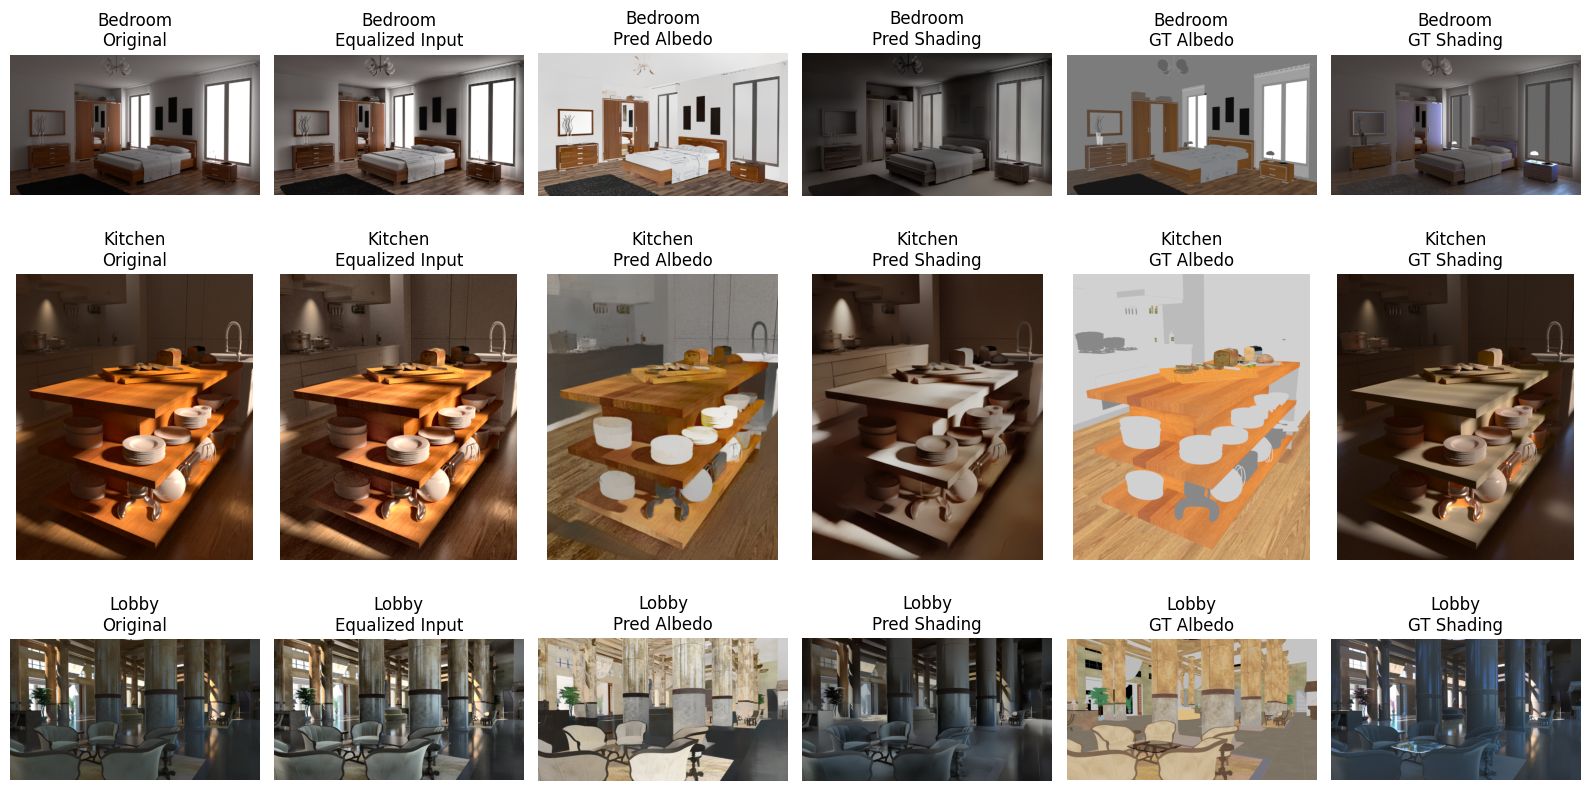

In [6]:
# 11. Qualitative Visualization: Original, Equalized Input, Pred (Alb/Shd), GT (Alb/Shd) for 3 ARAP images
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Paths (use earlier globals when available, else raw strings)
ARAP_INPUT = globals().get('ARAP_INPUT', r"E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\Input_Images")
ARAP_EQ_INPUT = globals().get('ARAP_EQ_INPUT', r"E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\histo_equal_input")
ARAP_EQ_OUTPUT_ALB = globals().get('ARAP_EQ_OUTPUT_ALB', r"E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\histo_equal_output\albedo")
ARAP_EQ_OUTPUT_SHD = globals().get('ARAP_EQ_OUTPUT_SHD', r"E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\histo_equal_output\shading")
GT_ALB_DIR = r"E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\Gt_Albedo"
GT_SHD_DIR = r"E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\Gt_Shading"

valid_exts = ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG']

def find_existing(base_dir, stem, suffix):
    """Find a file in base_dir matching stem + suffix + ext for common extensions."""
    for ext in valid_exts:
        p = os.path.join(base_dir, f"{stem}{suffix}{ext}")
        if os.path.exists(p):
            return p
    return None

def load_rgb(path):
    img = Image.open(path)
    if img.mode == 'RGBA':
        img = img.convert('RGB')
    return np.asarray(img)

# Build candidate stems ensuring all required assets exist
orig_files = [f for f in os.listdir(ARAP_INPUT) if f.lower().endswith(('.png','.jpg','.jpeg'))]
orig_files.sort()

stems = []
for f in orig_files:
    stem = os.path.splitext(f)[0]
    # Equalized input must exist with the same filename
    eq_in_path = os.path.join(ARAP_EQ_INPUT, f)
    if not os.path.exists(eq_in_path):
        continue
    # Predicted outputs
    pred_alb_path = find_existing(ARAP_EQ_OUTPUT_ALB, stem, '_alb')
    pred_shd_path = find_existing(ARAP_EQ_OUTPUT_SHD, stem, '_shd')
    # Ground truth
    gt_alb_path = find_existing(GT_ALB_DIR, stem, '_albedo')
    gt_shd_path = find_existing(GT_SHD_DIR, stem, '_shading')
    if pred_alb_path and pred_shd_path and gt_alb_path and gt_shd_path:
        stems.append((stem, os.path.join(ARAP_INPUT, f), eq_in_path, pred_alb_path, pred_shd_path, gt_alb_path, gt_shd_path))

if not stems:
    raise RuntimeError("No ARAP samples found where Original, Equalized Input, Pred (alb/shd), and GT (alb/shd) all exist. Run preprocessing/inference cells first.")

# Take first 3
samples = stems[:3]
print("Selected ARAP samples:", [s[0] for s in samples])

# Columns: [Original, Equalized Input, Pred Albedo, Pred Shading, GT Albedo, GT Shading]
cols = 6
rows = len(samples)
fig, axes = plt.subplots(rows, cols, figsize=(16, 3 * rows))
if rows == 1:
    axes = np.expand_dims(axes, 0)

for r, (stem, orig_p, eq_in_p, pr_alb_p, pr_shd_p, gt_alb_p, gt_shd_p) in enumerate(samples):
    orig = load_rgb(orig_p)
    eq_in = load_rgb(eq_in_p)
    pr_alb = load_rgb(pr_alb_p)
    pr_shd = load_rgb(pr_shd_p)
    gt_alb = load_rgb(gt_alb_p)
    gt_shd = load_rgb(gt_shd_p)

    panels = [
        ("Original", orig),
        ("Equalized Input", eq_in),
        ("Pred Albedo", pr_alb),
        ("Pred Shading", pr_shd),
        ("GT Albedo", gt_alb),
        ("GT Shading", gt_shd),
    ]
    for c, (title, img) in enumerate(panels):
        ax = axes[r, c]
        ax.imshow(img)
        ax.set_title(f"{stem}\n{title}")
        ax.axis('off')

plt.tight_layout()
plt.show()

Selected IIW samples: ['1014', '1068', '1094']


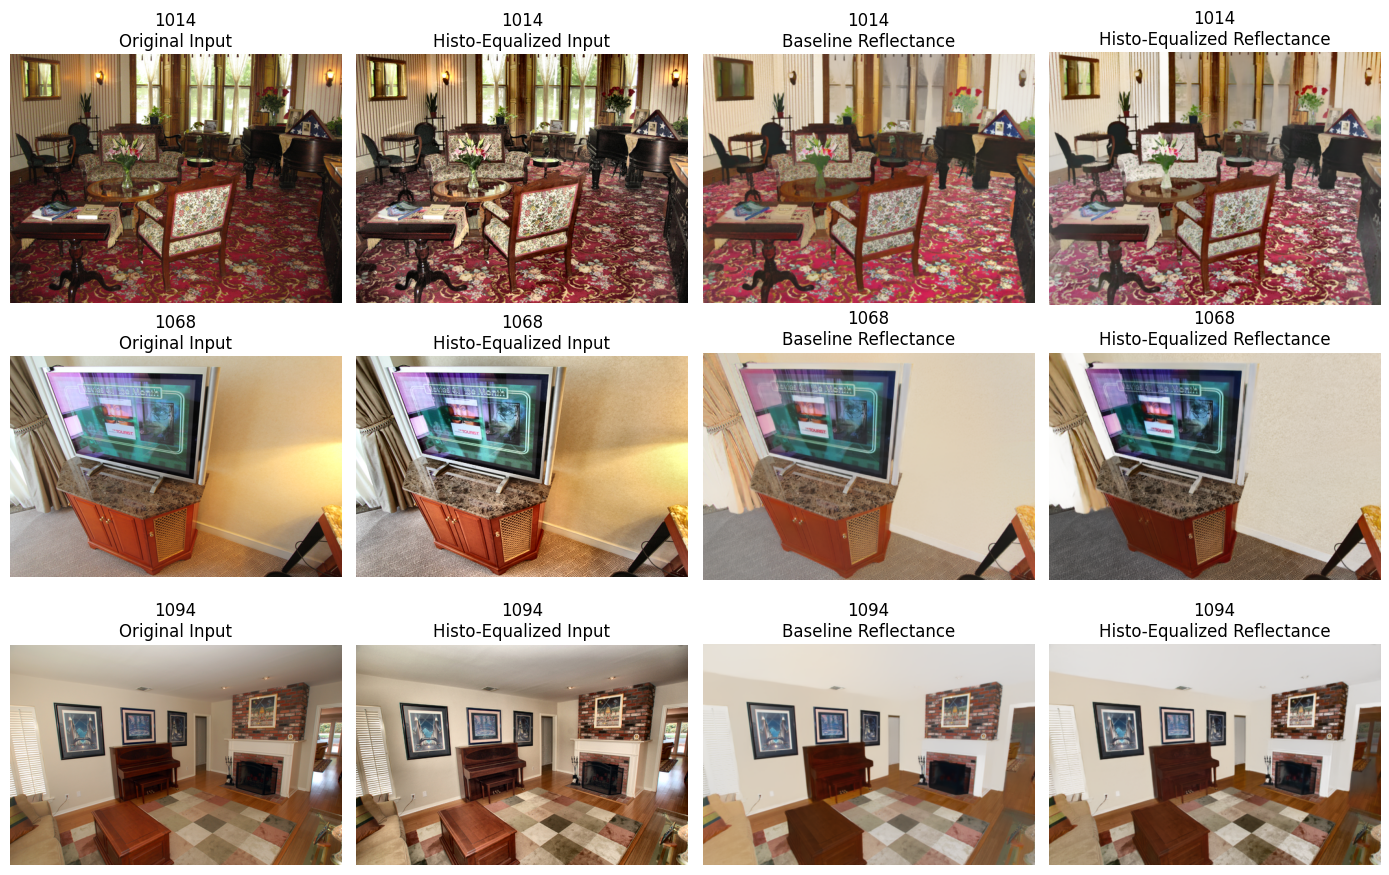

In [7]:
# 11B. IIW Qualitative Visualization: Original, Histo-Equalized Input, Baseline Reflectance, Histo-Equalized Reflectance (3 samples)
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Use globals where available, with sensible fallbacks
IIW_INPUT = globals().get('IIW_INPUT', r"E:\COLLEGE MATERIAL\Ordinal_Shading\IIW Dataset\data\images")
IIW_EQ_INPUT = globals().get('IIW_EQ_INPUT', r"E:\COLLEGE MATERIAL\Ordinal_Shading\IIW Dataset\data\histo_equal_images")
IIW_EQ_OUTPUT = globals().get('IIW_EQ_OUTPUT', r"E:\COLLEGE MATERIAL\Ordinal_Shading\IIW Dataset\data\histo_equal_output")
# Baseline (non-equalized) reflectance outputs produced by your baseline pipeline
IIW_BASE_OUTPUT = globals().get('IIW_OUTPUT', r"E:\COLLEGE MATERIAL\Ordinal_Shading\IIW Dataset\data\output")

valid_exts = ('.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG')


def load_rgb(path):
    img = Image.open(path)
    if img.mode == 'RGBA':
        img = img.convert('RGB')
    return np.asarray(img)

# Find images that have all four assets available
orig_files = [f for f in os.listdir(IIW_INPUT) if f.endswith(valid_exts)]
orig_files.sort()

candidates = []
for f in orig_files:
    stem = os.path.splitext(f)[0]
    orig_p = os.path.join(IIW_INPUT, f)
    eq_in_p = os.path.join(IIW_EQ_INPUT, f)
    base_refl_p = os.path.join(IIW_BASE_OUTPUT, f"{stem}_reflectance.png")
    eq_refl_p = os.path.join(IIW_EQ_OUTPUT, f"{stem}_reflectance.png")
    if all(os.path.exists(p) for p in [orig_p, eq_in_p, base_refl_p, eq_refl_p]):
        candidates.append((stem, orig_p, eq_in_p, base_refl_p, eq_refl_p))

if not candidates:
    raise RuntimeError("No IIW samples found with Original, Histo-Equalized input, Baseline reflectance, and Histo-Equalized reflectance. Ensure both baseline and equalized inference have been run.")

# Choose first 3 valid samples
samples = candidates[:3]
print("Selected IIW samples:", [s[0] for s in samples])

# Plot grid: [Original Input, Histo-Equalized Input, Baseline Reflectance, Histo-Equalized Reflectance]
rows = len(samples)
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(14, 3 * rows))
if rows == 1:
    axes = np.expand_dims(axes, 0)

for r, (stem, orig_p, eq_in_p, base_refl_p, eq_refl_p) in enumerate(samples):
    orig = load_rgb(orig_p)
    eq_in = load_rgb(eq_in_p)
    base_refl = load_rgb(base_refl_p)
    eq_refl = load_rgb(eq_refl_p)

    panels = [
        ("Original Input", orig),
        ("Histo-Equalized Input", eq_in),
        ("Baseline Reflectance", base_refl),
        ("Histo-Equalized Reflectance", eq_refl),
    ]
    for c, (title, img) in enumerate(panels):
        ax = axes[r, c]
        ax.imshow(img)
        ax.set_title(f"{stem}\n{title}")
        ax.axis('off')

plt.tight_layout()
plt.show()